### Import des données

In [1]:
import pandas as pd
import numpy as np 

df = pd.read_csv("clean_data.csv")
df["smoker_bmi"] = df["smoker"]*df["bmi"]
# df["smoker_age"] = df["smoker"]*df["age"]
df = df.drop(["age_category", "bmi_index", "sex_categ", "smoker_bmi", "bmi"], axis=1) # avec bmi_categories (donc 2 bmi)
df 

,age,sex,children,smoker,region,charges,bmi_categories
0,19,female,0,1,southwest,16884.92400,overweight
1,18,male,1,0,southeast,1725.55230,obesity class 1
2,28,male,3,0,southeast,4449.46200,obesity class 1
3,33,male,0,0,northwest,21984.47061,normal
4,32,male,0,0,northwest,3866.85520,overweight
...,...,...,...,...,...,...,...
1332,50,male,3,0,northwest,10600.54830,obesity class 1
1333,18,female,0,0,northeast,2205.98080,obesity class 1
1334,18,female,0,0,southeast,1629.83350,obesity class 2
1335,21,female,0,0,southwest,2007.94500,overweight


### Nettoyage/Encodage des données & pipelines, transformers, modèles...

In [2]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer 

from sklearn.preprocessing import PolynomialFeatures

# selection des features et de la cible
X = df.drop('charges', axis=1)
y = df.charges

# Création du train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

# Sélection des variables numériques
num_col = list(X.select_dtypes(include=[float,int]).columns)
# Sélection des variables catégorielles
cat_col = list(X.select_dtypes(include=[object]).columns)


# pipeline pour les valeurs numériques
# cela permet de créer une succession d'étapes (ici il n'y en a qu'une)
# my_num_pipe = make_pipeline()
# Créer un pipeline pour les variables catégorielles

onehotscale_pipeline = make_pipeline(OneHotEncoder(), RobustScaler(with_centering=False))
scale_pipeline = make_pipeline(RobustScaler(with_centering=False))

preprocessing = ColumnTransformer(
    transformers=[
        ('categorical', onehotscale_pipeline, cat_col),
        ('numerical', scale_pipeline, num_col)]
)

# scale_pipeline = make_pipeline(preprocessing)
polyscale_pipeline = make_pipeline(PolynomialFeatures(2))
my_final_pipeline = make_pipeline(preprocessing, polyscale_pipeline)
my_final_pipeline.fit(X_train)
feature_names = my_final_pipeline.get_feature_names_out(X.columns)
feature_names

# # ColumnTransformer permet de faire des opérations sur des sélections de colonnes
# preprocessing = ColumnTransformer([
# #     ("numeric", my_num_pipe, num_col),
#     ("categorical", categorical_pipeline, cat_col)],
#     remainder="passthrough")

# my_pipeline = make_pipeline(PolynomialFeatures(2), RobustScaler())

# preprocessing2 = ColumnTransformer([(my_pipeline, num_col, cat_col)])

array(['1', 'categorical__sex_female', 'categorical__sex_male',
       'categorical__region_northeast', 'categorical__region_northwest',
       'categorical__region_southeast', 'categorical__region_southwest',
       'categorical__bmi_categories_normal',
       'categorical__bmi_categories_obesity class 1',
       'categorical__bmi_categories_obesity class 2',
       'categorical__bmi_categories_obesity class 3',
       'categorical__bmi_categories_overweight',
       'categorical__bmi_categories_underweight', 'numerical__age',
       'numerical__children', 'numerical__smoker',
       'categorical__sex_female^2',
       'categorical__sex_female categorical__sex_male',
       'categorical__sex_female categorical__region_northeast',
       'categorical__sex_female categorical__region_northwest',
       'categorical__sex_female categorical__region_southeast',
       'categorical__sex_female categorical__region_southwest',
       'categorical__sex_female categorical__bmi_categories_normal'

In [18]:
my_final_pipeline

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder()),
                                                                                   ('robustscaler',
                                                                                    RobustScaler(with_centering=False))]),
                                                                   ['sex',
                                                                    'region',
                                                                    'bmi_categories']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('robustscaler',
                                                                                    RobustScaler(with_centering=False))]),
                                                                   ['age',
                                                                    'children',
                                                                    'smoker'])]))])),
                ('pipeline-2',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures())]))])

In [3]:
# # TESTS DES COEFFICIENTS PB

# from sklearn.pipeline import make_pipeline
# from sklearn.dummy import DummyRegressor
# from sklearn.preprocessing import RobustScaler, OneHotEncoder, PolynomialFeatures, StandardScaler
# from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
# from sklearn.model_selection import train_test_split
# from sklearn.compose import ColumnTransformer 

# from sklearn.preprocessing import PolynomialFeatures

# # selection des features et de la cible
# X = df.drop('charges', axis=1)
# y = df.charges


# # Création du train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])

# # Sélection des variables numériques
# num_col = list(X.select_dtypes(include=[float, int]).columns)
# # Sélection des variables catégorielles
# cat_col = list(X.select_dtypes(include=[object]).columns)

# # Pipeline pour les valeurs numériques
# my_num_pipe = make_pipeline(PolynomialFeatures(2), RobustScaler())
# # Créer un pipeline pour les variables catégorielles
# categorical_pipeline = make_pipeline(OneHotEncoder(), PolynomialFeatures(2))

# # ColumnTransformer permet de faire des opérations sur des sélections de colonnes
# preprocessing = ColumnTransformer([
#     ("numeric", my_num_pipe, num_col),
#     ("categorical", categorical_pipeline, cat_col)
# ])

# # Créer le modèle Lasso
# lasso_model = Lasso(alpha=1.0, random_state=42)

# # Créer le pipeline complet
# full_pipeline = make_pipeline(preprocessing, lasso_model)

# # Entraîner le modèle
# full_pipeline.fit(X_train, y_train)

# # Accéder au modèle dans le pipeline
# lasso_model = full_pipeline[-1]

# # Accéder aux coefficients
# coefficients = lasso_model.coef_

# # Afficher les résultats
# result = list(zip(X.columns, coefficients))
# for tuple in result:
#     print(tuple)

In [4]:
# import pandas as pd
# from sklearn.pipeline import make_pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import RobustScaler, OneHotEncoder, PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split


# # Features and target
# X = df.drop('charges', axis=1)
# y = df['charges']

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42)

# # Numeric columns
# num_col = list(X.select_dtypes(include=[float, int]).columns)

# # Categorical columns
# cat_col = list(X.select_dtypes(include=[object]).columns)

# # Numeric pipeline
# num_pipe = make_pipeline(PolynomialFeatures(2, include_bias=False), RobustScaler())

# # Categorical pipeline
# cat_pipe = make_pipeline(OneHotEncoder(), PolynomialFeatures(2, include_bias=False))

# # ColumnTransformer
# preprocessing = ColumnTransformer([
#     ("numeric", num_pipe, num_col),
#     ("categorical", cat_pipe, cat_col)
# ])

# # # Full pipeline including preprocessing and linear regression
# full_pipeline = make_pipeline(preprocessing, LinearRegression())

# # # Fit the pipeline to the training data
# full_pipeline.fit(X_train, y_train)

# # Extract coefficients from the linear regression model

# coefficients = my_pipe_lr[-1].coef_

# result = list(zip(X.columns, coefficients))
# for tuple in result:
#     print(tuple)
# #print(result)

In [5]:
# age' (0.0): L'âge n'a apparemment aucune contribution à la prédiction de la variable cible (peut-être qu'il est exclu du modèle en raison du terme Lasso).
# 'sex' (-2516.853191426364): Une unité d'augmentation dans la variable 'sex' est associée à une diminution d'environ 2516.85 unités dans la variable cible (en supposant que toutes les autres variables restent constantes).
# 'bmi' (259.155002102034): Une unité d'augmentation dans la variable 'bmi' est associée à une augmentation d'environ 259.16 unités dans la variable cible.
# 'children' (2030.5049181589575): Une unité d'augmentation dans la variable 'children' est associée à une augmentation d'environ 2030.50 unités dans la variable cible.
# 'smoker' (-13230.800216679068): Si le patient est un fumeur (1), cela est associé à une diminution significative d'environ 13230.80 unités dans la variable cible par rapport à un non-fumeur (0).
# 'region' (682.2261542909383): La variable 'region' a une contribution positive d'environ 682.23 unités à la variable cible.
# 'bmi_categories' (8670.04922615023): La variable 'bmi_categories' a une contribution positive d'environ 8670.05 unités à la variable cible.
# 'smoker_bmi' (160.33348543225566): Une unité d'augmentation dans la variable 'smoker_bmi' est associée à une augmentation d'environ 160.33 unités dans la variable cible.

#### Voir si les données ont bien été modifiées

In [6]:
# Appliquez le pipeline sur les données d'entraînement et de test
# X_train_transformed = preprocessing.fit_transform(X_train)
# X_train_transformed

In [7]:
# # Supposez que X_train_transformed soit une matrice NumPy résultante de la transformation
# # Appliquer le ColumnTransformer sur les données d'entraînement
# X_train_transformed = preprocessing.fit_transform(X_train)

# # Obtenez les noms de colonnes après la transformation
# all_columns = preprocessing.transformers_[0][1].get_feature_names_out(cat_col).tolist() + num_col

# # Créez un DataFrame pandas à partir des données transformées et des noms de colonnes
# X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_columns)

# # Affichez le DataFrame
# print(X_train_transformed_df.head())

### DummyRegressor

In [8]:
# DUMMY REGRESSOR (ne prend pas en compte les variables, prédit la moyenne de chaque valeur Y)
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)
print(f"regression dummy : {dummy_regr.score(X_test, y_test)}")

regression dummy : -0.0020162626112618653


### LinearRegression

In [9]:
# REGRESSION LINEAIRE
# j'ajoute la régression linéaire au pipeline
my_pipe_lr = make_pipeline(my_final_pipeline, LinearRegression())
# Je fit sur les données
my_pipe_lr.fit(X_train, y_train)
# afficher le score
print(f"regression linéaire : {my_pipe_lr.score(X_test, y_test)}")

regression linéaire : 0.9001168669487777


In [10]:
# Faire une prédiction sur de nouvelles données
y_pred = my_pipe_lr.predict(X_test)

# X_new doit être un tableau ou une liste contenant les
# caractéristiques des nouvelles données sur lesquelles vous voulez faire des prédictions.

# Afficher les prédictions
print("Prédictions :", y_pred)

Prédictions : [ 2576. 37456.  6224. 43776. 36384.  7776.  3584.  4368.  2944. 41376.
  9504. 12272.  3168.  9472.  3648.  3136.  1856.  6080.  4928. 18976.
 14272. 10016. 12864. 13632.  5984.  2528. 13440. 12448.  3168.  2848.
  5152. 12064. 11328. 18752. 36272. 45744.  3488. 12736. 15168.  9680.
  6240.  6592. 26176. 18400. 28528.  3008. 11840. 12640. 39424. 13056.
  5856. 44448. 15056. 13280.  3984. 16096.  8560. 10816.  8704.  5280.
  4832. 41200. 13824. 10880. 16704. 17536.  3696. 11984.  5792.  6928.
  5824. 10384. 28384.  7600. 47408.  7712.  5584.  7744. 13472. 24912.
  2048.  2640.  9792. 25344. 11488. 41168. 10464.  4480. 12192. 14272.
  9312. 29152. 14544. 10240.  4608.  3712.  6720.  4080.  5984. 11328.
  6064.  6048.  4240.  5792.  3424. 40096.  6352. 12704.  4368. 10240.
 15984.  6368. 10224. 10720. 11504. 10208.  6976.  6368. 14688. 16592.
 14784. 11408.  2544. 19616. 22528. 11136. 10192.  7392. 10432. 40384.
  7200.  6576.  3936.  4224.  3312. 10656. 14848.  6400. 10128.

In [11]:
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_pred)
print(f"r2 : {r2}")
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"rmse : {rmse}")

r2 : 0.9001168669487777
rmse : 3804.555558684684


In [12]:
# Extract coefficients from the linear regression model
coefficients = my_pipe_lr[-1].coef_
result = list(zip(feature_names, coefficients))
# for tuple in result:
#     print(tuple)

liste = []
for i in range(len(result)):
    liste.append(list([result[i][0], result[i][-1]]))

sorted(liste, reverse=False)
# feature_names = preprocessing.get_feature_names_out(X.columns)
# feature_names

[['1', 3466080055560.0557],
 ['categorical__bmi_categories_normal', -8341659109419295.0],
 ['categorical__bmi_categories_normal categorical__bmi_categories_obesity class 1',
  0.0],
 ['categorical__bmi_categories_normal categorical__bmi_categories_obesity class 2',
  0.0],
 ['categorical__bmi_categories_normal categorical__bmi_categories_obesity class 3',
  0.0],
 ['categorical__bmi_categories_normal categorical__bmi_categories_overweight',
  0.0],
 ['categorical__bmi_categories_normal categorical__bmi_categories_underweight',
  0.0],
 ['categorical__bmi_categories_normal numerical__age', -2.820010624893925e+16],
 ['categorical__bmi_categories_normal numerical__children',
  -403194199050896.0],
 ['categorical__bmi_categories_normal numerical__smoker',
  1.2621497866437118e+16],
 ['categorical__bmi_categories_normal^2', -8.434405401572654e+16],
 ['categorical__bmi_categories_obesity class 1', -1.9274396629202372e+16],
 ['categorical__bmi_categories_obesity class 1 categorical__bmi_categ

In [13]:
# my_pipe_lr[-1].coef_
# plus le coef est gros plus l'info est importante
# coef des variables (avec polynomialfeatures)

In [14]:
# # Extract coefficients from the linear regression model
# coefficients = my_pipe_lr[-1].coef_
# poly = PolynomialFeatures(2)
# # Extract feature names from PolynomialFeatures after fitting
# poly_feature_names = poly.get_feature_names_out(X.columns)

# # Create a DataFrame with coefficients and feature names
# coef_df = pd.DataFrame({'Feature': poly_feature_names, 'Coefficient': coefficients})

# # Display the DataFrame
# print(coef_df)

In [15]:
# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import make_pipeline

# # selection des features et de la cible
# X = X
# y = y

# # Create polynomial features and linear regression
# degree = 2  # You can adjust the degree as needed
# poly = PolynomialFeatures(degree)

# # Fit the pipeline to the data
# my_pipe_lr.fit(X, y)

# # Extract coefficients from the linear regression model
# coefficients = my_pipe_lr[-1].coef_

# # Extract feature names from PolynomialFeatures
# poly_feature_names = poly.get_feature_names_out(X.columns)

# # Create a DataFrame with coefficients and feature names
# coef_df = pd.DataFrame({'Feature': poly_feature_names, 'Coefficient': coefficients})

# # Display the DataFrame
# print(coef_df)

### Lasso

In [16]:
# REGRESSION LASSO CV
my_pipe_lasso = make_pipeline(my_final_pipeline, Lasso(alpha=46.5))  # avant 21.5, 46.5
# Je fit sur les données
my_pipe_lasso.fit(X_train, y_train)
# le score
print(f"regression lasso : {my_pipe_lasso.score(X_test, y_test)}")



import pickle 
# Sauvegarde du modèle en fichier .pkl
with open('modele.pkl', 'wb') as file:
    pickle.dump(my_pipe_lasso, file)

regression lasso : 0.9108584681728484


In [17]:
my_pipe_lasso[-1].coef_.set_output(transform="pandas")

AttributeError: 'numpy.ndarray' object has no attribute 'set_output'

In [ ]:
my_pipe_lasso[-1].coef_

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.97594880e+02,
       -8.45822930e+01,  5.87114077e+03,  6.33410505e+02,  3.16886071e+02,
       -5.01555471e+01, -0.00000000e+00,  7.00364340e+02,  1.26656251e+03,
        0.00000000e+00, -1.97681416e+02, -1.25851721e+04,  0.00000000e+00,
        3.57205553e+02, -1.02510050e-13,  7.83441452e+02,  1.90883443e+02,
       -4.02143648e+00, -1.44815786e+02,  3.97797818e+00,  0.00000000e+00,
        6.57747920e+01,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -1.63600215e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -2.95479068e+01,  3.67600547e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.43123564e+01,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -1.08506672e+00])

In [ ]:
diccc = {"age" : [18], "sex" : ["male"], "bmi" : [33.75], "children" : [1], "smoker" : [0], "region" : ["southeast"]}
dicc_test = pd.DataFrame(diccc)
dicc_test 

y_pred = my_pipe_lasso.predict(dicc_test)
print("Prédictions :", y_pred)

Prédictions : [3170.01066975]


In [ ]:
with open('modele.pkl', 'rb') as file:
    model = pickle.load(file)
    prediction = model.predict(dicc_test)
    # st.markdown(f"<span style='color:green; font-size:54px;'>**{round(prediction[0], 4)} $**</span>", unsafe_allow_html=True)
    print(prediction)

[3313.35318792]


In [ ]:
# Faire une prédiction sur de nouvelles données
y_pred = my_pipe_lasso.predict(X_test)

# X_new doit être un tableau ou une liste contenant les
# caractéristiques des nouvelles données sur lesquelles vous voulez faire des prédictions.

# Afficher les prédictions
print("Prédictions :", y_pred)

Prédictions : [ 2896.32542862 34615.24959518  6817.58395152 40315.67969076
 29870.85040697  6720.09221397  3920.56053489  3644.48065378
  2782.88365986 39287.29341243 10168.28544795 12367.3112207
  3172.03368701 16151.85076511  2814.57700023  2718.44292897
  2467.80300895  6750.45332908  3655.5835854  22921.22634191
 13835.03344543  9925.15791707 13151.1141922  14476.20955182
  6046.71800933  3058.73985782 12452.9917033  10915.84098141
  3194.16053452  3398.50563005  4129.04162918 12793.16082764
 10837.40087924 21821.09878521 29885.02967513 47390.62440313
  3693.04014016 13140.07974901 18111.32571552 11237.40734726
  6327.89198618  5730.48865137 28415.77025998 16584.24023996
 30856.0317457   3786.29921779 11415.71825654 12043.51348306
 42955.32674092 11219.77997096  4827.79414133 39269.04557891
 15303.98823325 13663.99559415  3183.71702697 15706.18875107
  7423.87284335  9846.03473055  9380.13318758  5196.71540198
  4345.23703775 39700.94328556 12779.60810035  9998.92660314
 15637.8935

In [ ]:
df.head(3) 

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,1,southwest,16884.9240
1,18,male,33.77,1,0,southeast,1725.5523
2,28,male,33.00,3,0,southeast,4449.4620


In [ ]:
#from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_pred)
print(f"r2 : {r2}")
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"rmse : {rmse}")

r2 : 0.90345728576361
rmse : 3740.3961785003735


In [ ]:
# R²

# R² mesure la proportion de la variance de la variable dépendante
# (la variable que vous essayez de prédire) qui est expliquée par le modèle.
# Une valeur de R² proche de 1.0 indique un bon ajustement du modèle aux données,
# signifiant que le modèle explique une grande partie de la variabilité de la variable dépendante.
# Dans notre cas, un R² de 0.904 suggère que votre modèle explique environ 90.4%
# de la variance dans les données de test. C'est généralement considéré comme un bon ajustement.

# RMSE

# RMSE mesure l'écart moyen entre les valeurs réelles et les valeurs prédites par le modèle.
# Il est exprimé dans les mêmes unités que la variable dépendante.
# Une valeur de RMSE plus basse indique une meilleure performance du modèle.
# Dans notre cas, un RMSE de 3730.38 indique que, en moyenne, les prédictions de notre modèle
# ont une erreur d'environ 3730.38 unités par rapport aux valeurs réelles.


# Conclusion

# En résumé, avec un R² élevé et un RMSE relativement bas,
# il semble que votre modèle de régression linéaire performe bien sur les données de test.
# Cependant, il est toujours recommandé de compléter ces scores avec
# une analyse visuelle des résidus et d'autres métriques d'évaluation,
# en fonction du contexte spécifique de votre problème.

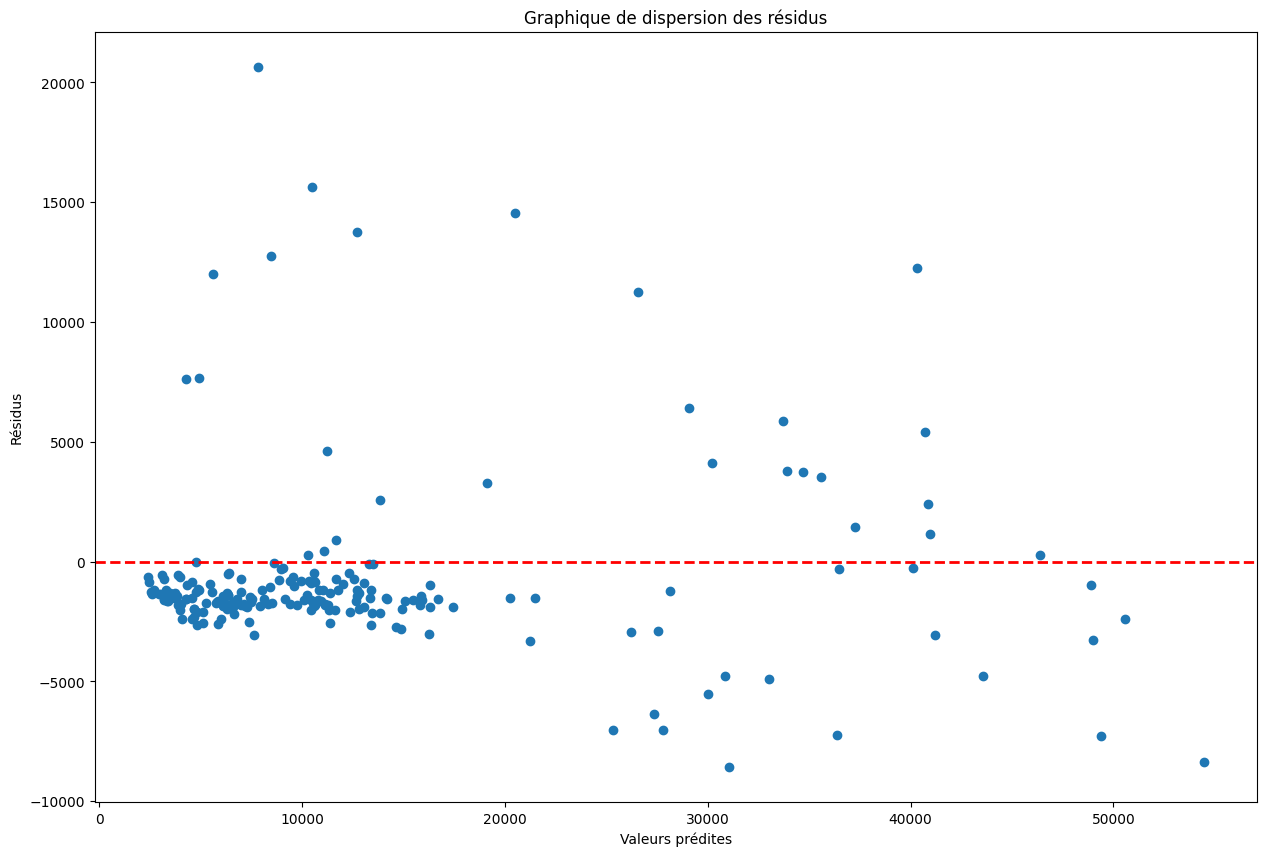

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Faire des prédictions sur les données de test
y_pred = my_pipe_lr.predict(X_test)

# Calculer les résidus
residuals = y_test - y_pred

# Tracer le graphique de dispersion entre les valeurs prédites et les résidus
plt.figure(figsize=(15,10))
plt.scatter(y_pred, residuals)
#sns.scatterplot(y_pred)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Ajouter une ligne horizontale à y=0 pour référence
plt.title('Graphique de dispersion des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
param = {"lasso__alpha" : np.arange(0.5,50, 0.5)}

grid = GridSearchCV(my_pipe_lasso, param, cv=5)
grid.fit(X_train, y_train)

/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e+10, tolerance: 1.315e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e+10, tolerance: 1.298e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/sit

/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.115e+10, tolerance: 1.381e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.511e+09, tolerance: 1.271e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/sit

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('polynomialfeatures',
                                                                                          PolynomialFeatures()),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children',
                                                                          'smoker']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder()),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures())]),
                                                                         ['...
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ,
       22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5,
       28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. ,
       33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5,
       39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. ,
       44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5])})

In [ ]:
len(np.arange(0.01,10, 0.1))

100

In [ ]:
grid.best_params_

{'lasso__alpha': 6.0}

### Ridge

In [ ]:
# REGRESSION RIDGE CV 
my_pipe_ridge = make_pipeline(my_final_pipeline, Ridge(alpha=1e-05))
# Je fit sur les données
my_pipe_ridge.fit(X_train, y_train)
# le score
print(f"regression ridge : {my_pipe_ridge.score(X_test, y_test)}")

regression ridge : 0.8992739862644407


In [ ]:
from sklearn.model_selection import GridSearchCV
param = {"ridge__alpha" : np.arange(0.00001, 0.0001, 0.05)}

grid = GridSearchCV(my_pipe_ridge, param, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('polynomialfeatures',
                                                                                          PolynomialFeatures()),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children',
                                                                          'smoker']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder()),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures())]),
                                                                         ['sex',
                                                                          'region'])])),
                                       ('ridge', Ridge(alpha=1e-05))]),
             param_grid={'ridge__alpha': array([1.e-05])})

In [ ]:
grid.best_params_

{'ridge__alpha': 1e-05}

### ElasticNet

In [ ]:
# REGRESSION ELASTICNETCV
my_pipe_elasticnet = make_pipeline(my_final_pipeline, ElasticNet(alpha=9.1e-05)) # avant alpha = 0.01
# Je fit sur les données
my_pipe_elasticnet.fit(X_train, y_train)
# le score
print(f"regression elasticnet : {my_pipe_elasticnet.score(X_test, y_test)}")

# si l1_ratio = 1 alors elasticnet devient un lasso
# si l1_ratio = 0 alors elasticnet devient un ridge

regression elasticnet : 0.9079316829162473


/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e+10, tolerance: 1.667e+07
  model = cd_fast.enet_coordinate_descent(


In [ ]:
from sklearn.model_selection import GridSearchCV
param = {"elasticnet__alpha" : np.arange(0.000001, 0.0001, 0.00001),
         "elasticnet__l1_ratio" : np.arange(0.001, 1, 0.1)}

grid = GridSearchCV(my_pipe_elasticnet, param, cv=5)
grid.fit(X_train, y_train)

# np.arange(0.000001, 0.0001, 0.1)

/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+10, tolerance: 1.315e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.139e+10, tolerance: 1.298e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/DEV-IA/projets/machine_learning_assurance/machinelearning_assurance/.venv/lib/python3.11/sit

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('polynomialfeatures',
                                                                                          PolynomialFeatures()),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children',
                                                                          'smoker']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder()),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures())]),
                                                                         ['sex',
                                                                          'region'])])),
                                       ('elasticnet',
                                        ElasticNet(alpha=9.1e-05))]),
             param_grid={'elasticnet__alpha': array([1.0e-06, 1.1e-05, 2.1e-05, 3.1e-05, 4.1e-05, 5.1e-05, 6.1e-05,
       7.1e-05, 8.1e-05, 9.1e-05]),
                         'elasticnet__l1_ratio': array([0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801,
       0.901])})

In [ ]:
len(np.arange(0.000001, 0.0001, 0.000001))

100

In [ ]:
grid.best_params_

{'elasticnet__alpha': 9.1e-05, 'elasticnet__l1_ratio': 0.001}

In [ ]:
poly = PolynomialFeatures(2).fit_transform